<a href="https://colab.research.google.com/github/rujool11/ML-learning/blob/main/04_transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Transfer learning part 1 : feature extraction**


1. Can leverage existing neural networks proven to work well with problems similar to our own

2. Can leverage existing neural network architecture which has already learned similar patterns

In [1]:
import zipfile

# get data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip data
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-10-10 09:05:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.1MB/s    in 9.2s    

2023-10-10 09:06:07 (17.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

there are 2 directories and 0 images in 10_food_classes_10_percent
there are 10 directories and 0 images in 10_food_classes_10_percent/train
there are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
there are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
there are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
there are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
there are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
there are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
there are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
there are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
there are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
there are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
there are 10 director

In [3]:
# as we can see, we have less train data this time


### **Prepare Data Loaders**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('training images')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical',
                                                          shuffle=True)

print('test images')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

training images
Found 750 images belonging to 10 classes.
test images
Found 2500 images belonging to 10 classes.


### **Callbacks**

extra functionality you can add to model during or after training

Eg. --

1. TensorBoard callback to track experiments

2. ModelCheckpoint callback (self explanatory)

3. EarlyStopping callback to stop model before overfitting

In [5]:
# Tensorboard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  # creating directory path to store
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%m-%H%M%S") # strftime - string from time, and format of date is passed
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'saving tensorboard log files to {log_dir}')
  return tensorboard_callback;

### **Creating models using TensorFlow Hub**

we can access pretrained models on (https://tfhub.dev)

found feature vector model link: (https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2)

In [6]:
# let us compare two models --

efficientnet_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
def create_model(model_url, num_classes=10):
  '''
  takes tensorflow hub url and creates models

  args:
    model_url - tensorflow hub model url (feature extraction)
    num_classes - number of classes (output neurons)

  returns:
    uncompiled tensorflow model with model_url as feature extractor
    and Dense output layers with num_classes as output neurons

  '''

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze already learned patterns, since this is pretrained
                                           name='feature_extractor_layer',
                                           input_shape=IMG_SHAPE + (3, ))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [8]:
# create resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 2048)              23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [10]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [11]:
res_hist_1 = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                        experiment_name='resnetv250')
                                                        ])

saving tensorboard log files to tensorflow_hub/resnetv250/20231010-090630
Epoch 1/5
24/24 [==============================] - 28s 632ms/step - loss: 2.0356 - accuracy: 0.3200 - val_loss: 1.2810 - val_accuracy: 0.5700
Epoch 2/5
24/24 [==============================] - 14s 579ms/step - loss: 0.9436 - accuracy: 0.7293 - val_loss: 0.8729 - val_accuracy: 0.7188
Epoch 3/5
24/24 [==============================] - 13s 539ms/step - loss: 0.6414 - accuracy: 0.8173 - val_loss: 0.7855 - val_accuracy: 0.7400
Epoch 4/5
24/24 [==============================] - 11s 472ms/step - loss: 0.4931 - accuracy: 0.8773 - val_loss: 0.7309 - val_accuracy: 0.7544
Epoch 5/5
24/24 [==============================] - 11s 479ms/step - loss: 0.3899 - accuracy: 0.9067 - val_loss: 0.6891 - val_accuracy: 0.7652


In [12]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss = history.history['loss']
  accuracy = history.history['accuracy']

  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']

  epochs=range(len(loss))

  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='valdation_loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training accuracy')
  plt.plot(epochs, val_accuracy, label='valdation_accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend();

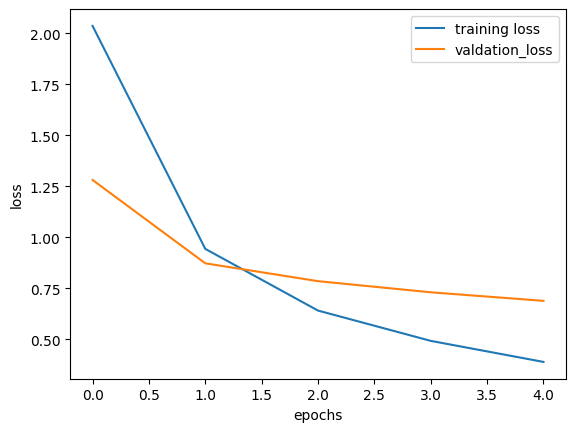

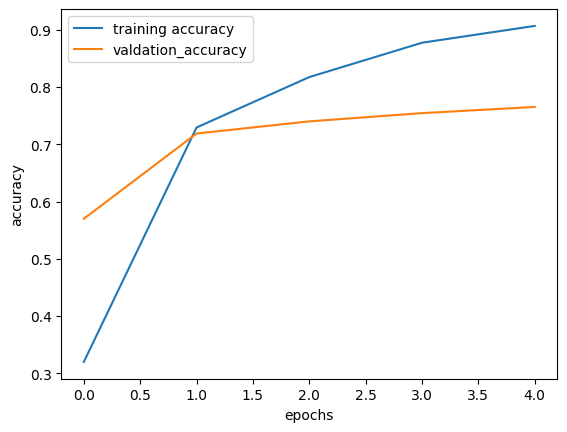

In [13]:
plot_loss_curves(res_hist_1)

In [14]:
# trains much better, has to be kept in mind that this is using only 10% of all training data
# building efficientnet model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1280)              5919312   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [15]:
eff_hist_1 = efficientnet_model.fit(train_data_10_percent,
                                    epochs=5,
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data,
                                    validation_steps=len(test_data),
                                    callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                          experiment_name='efficientnet')
                                                                          ])

saving tensorboard log files to tensorflow_hub/efficientnet/20231010-091712
Epoch 1/5
24/24 [==============================] - 21s 506ms/step - loss: 1.9765 - accuracy: 0.3507 - val_loss: 1.5175 - val_accuracy: 0.6300
Epoch 2/5
24/24 [==============================] - 10s 414ms/step - loss: 1.3029 - accuracy: 0.6827 - val_loss: 1.1276 - val_accuracy: 0.7112
Epoch 3/5
24/24 [==============================] - 11s 455ms/step - loss: 1.0031 - accuracy: 0.7493 - val_loss: 0.9527 - val_accuracy: 0.7464
Epoch 4/5
24/24 [==============================] - 10s 407ms/step - loss: 0.8407 - accuracy: 0.8013 - val_loss: 0.8576 - val_accuracy: 0.7596
Epoch 5/5
24/24 [==============================] - 9s 384ms/step - loss: 0.7331 - accuracy: 0.8253 - val_loss: 0.7998 - val_accuracy: 0.7692


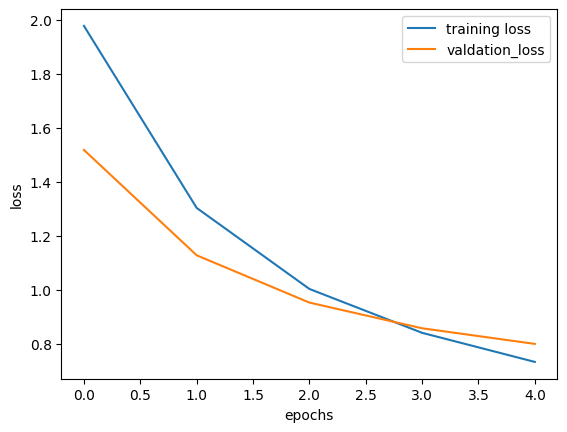

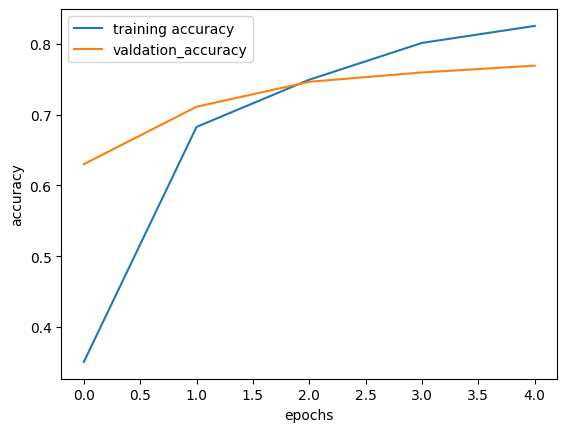

In [16]:
plot_loss_curves(eff_hist_1)

### **Types of transfer learning**

1. **"As is"** - using external model with no changes at all  -- nothing is changed

2. **"Feature Extraction"** - using prelearned patterns of existing model and adjust outout layers as required -- only output layers are changed

3. **"Fine tuning"** - use prelearned patterns of existing model and fine tune any or all of the layers, including adding new layers -- any or all of the layers are changed